# Exploratory Data Analysis

&lt; Work in progress &gt;


In [106]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv').head(20000) # crop because battery life
# Make float better readable
pd.options.display.float_format = '{:.0f}'.format

### First Look

In [107]:
df_art.head(3)

,tId,article_id,updated,num_comments,link,header,sub,text
0,31538566,31538566,1502083635,0,/schweiz/news/story/31538566,«Für mich ist eine Welt zusammengebrochen»,Beim Flugzeugunglück bei Pontresina starben dr...,Im Bündner Diavolezza-Gebiet ist ein Flugzeug ...
1,19638181,19638181,1502197771,43,/schweiz/zuerich/story/19638181,Jetzt wird die Schwester der Europaallee gebaut,Gleisarena und Gleistribüne  so heissen die e...,Die neue Überbauung HB-Nord entsteht nördlich ...
2,31833243,31833243,1502299764,0,/schweiz/basel/story/Fuenffacher-Nachwuchs-im-...,Fünffacher Nachwuchs im Basler Affenhaus,Bei den Totenkopfäfflein im Basler Zoo gibt es...,Die fünf Totenkopfäffchen wurden zwischen Mitt...


In [108]:
df_com.head(3)

,tId,cId,mob,vup,vdo,tit,aut,time,con
0,24298157,3_127,1,2,0,@Thomas,Spaniel,am 21.07.2017 12:14,Es würde Streit geben wenn er aufgespannt wir...
1,13753138,1115_1225,0,21,1,ohne Partikelfilter,Heinz B.,am 05.08.2017 17:25,@Historiker: Aber im Gegensatz zu Baumaschine...
2,13340147,783_783,1,87,14,Nur Abzocker,KChav,am 09.08.2017 15:45,Jetzt kann die Zürcher Taxi Maffia wieder los...


In [109]:
print(df_art.shape)
print(df_com.shape)

(1026, 8)
(30000, 9)


In [110]:
print(df_art.dtypes)
print(' ')
print(df_com.dtypes)

tId               int64
article_id        int64
updated         float64
num_comments      int64
link             object
header           object
sub              object
text             object
dtype: object
 
tId      int64
cId     object
mob      int64
vup      int64
vdo      int64
tit     object
aut     object
time    object
con     object
dtype: object


In [111]:
df_art.describe()

# Summary:
# No missing attributes since count is the same everywhere
# No negative values, chi^2 etc. can be used

,tId,article_id,updated,num_comments
count,1026,1026,1026,1026
mean,21144399,21143338,1502274052,77
std,6430672,6435194,129408,136
min,10003016,10003016,1502017728,0
25%,15604268,15604268,1502172556,0
50%,21220790,21220790,1502288367,28
75%,26632181,26655490,1502414371,84
max,31996579,31996579,1502425549,1171


In [112]:
df_com.describe()

# Summary:
# No missing attributes 
# No negative values

,tId,mob,vup,vdo
count,30000,30000,30000,30000
mean,20859722,1,44,16
std,6427803,0,111,34
min,10003016,0,0,0
25%,15257569,0,7,2
50%,20500325,1,20,6
75%,26734002,1,44,16
max,31996579,1,3543,944


In [113]:
print(df_art.skew())
# Makes only sense on 'num_comments'

tId             0
article_id      0
updated        -0
num_comments    3
dtype: float64


In [114]:
print(df_com.skew())
# Skew is not high enough that it has to be corrected

tId    0
cId    3
mob   -1
vup   11
vdo    8
dtype: float64


### Feature Engineering
To make further analysis possible concerning time features.

In [137]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

### Class Distribution

In [116]:
# 'df_art' has no classes

# 'df_com' 
print(df_com.groupby('mob').size())
#print(df_com.groupby('hour').size())
print(df_com.groupby('weekday').size())

mob
0     9666
1    20334
dtype: int64
weekday
0    2666
1    4446
2    6479
3    5499
4    3538
5    3642
6    3730
dtype: int64


### Correlation
Let's find relations between some of the attributes. Correlation requires continuous data.

In [133]:
# Only for these columns
cols = ['score', 'contr', 'hour', 'weekday', 'weekday_fl', 'mob', 'vup', 'vdo', 'is_answer', 'con_len']

# Change back how float is displayed
pd.options.display.float_format = '{:.2f}'.format

# Get pearson co-efficients
df_corr = df_com[cols].corr()
df_corr

# Summary:
# Correlations are low.
# The only interesting correlation is between 'vup' and 'vdo'.

,score,contr,hour,weekday,weekday_fl,mob,vup,vdo,is_answer,con_len
score,1.00,0.84,-0.01,-0.02,-0.02,0.04,0.95,0.07,-0.14,0.01
contr,0.84,1.00,-0.01,-0.02,-0.02,0.08,0.97,0.59,-0.22,0.02
hour,-0.01,-0.01,1.00,-0.00,0.12,0.03,-0.01,-0.00,0.03,-0.06
weekday,-0.02,-0.02,-0.00,1.00,0.99,0.07,-0.02,-0.01,0.07,-0.02
weekday_fl,-0.02,-0.02,0.12,0.99,1.00,0.07,-0.02,-0.01,0.08,-0.02
mob,0.04,0.08,0.03,0.07,0.07,1.00,0.06,0.09,0.32,-0.13
vup,0.95,0.97,-0.01,-0.02,-0.02,0.06,1.00,0.37,-0.19,0.02
vdo,0.07,0.59,-0.00,-0.01,-0.01,0.09,0.37,1.00,-0.19,0.01
is_answer,-0.14,-0.22,0.03,0.07,0.08,0.32,-0.19,-0.19,1.00,-0.14
con_len,0.01,0.02,-0.06,-0.02,-0.02,-0.13,0.02,0.01,-0.14,1.00


### Scatter plots

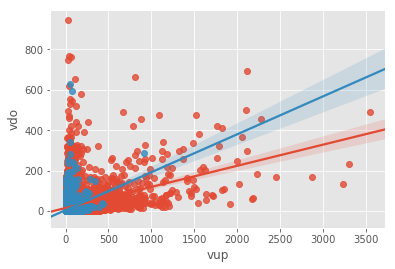

In [166]:
#sns.pairplot(df_com, x_vars='vup', y_vars='vdo', size=6)
sns.regplot(x='vup', y='vdo', data=df_com[df_com['is_answer'] == False])
sns.regplot(x='vup', y='vdo', data=df_com[df_com['is_answer'] == True])
plt.show()

# Quite some outliers
# Are rows with upvotes of over 1000 real?
# Looked some of them up manually and yes, they have a lot of upvotes (3000+)
# Answers are rather downvoted than upvoted (as can already be seen in the correlation matrix)

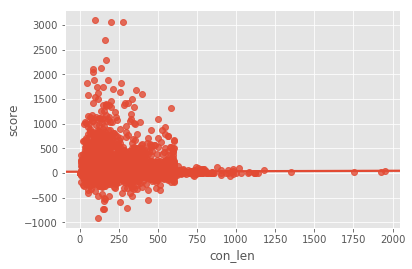

In [156]:
#sns.regplot(x='vup', y='vdo', data=df_com[df_com['vup'] < 200])
sns.regplot(x='con_len', y='score', data=df_com)
plt.show()

### Prediction
Ok... I want to know:
* How to get the best score/consensus (upvotes - downvotes)?
* How to be most controversial (upvotes + downvotes)?
* Which articles go most score / were most controversial (sum over all comments)?

...And in the end I want a model predicting my comment text with given day and hour of posting.

Impact will be taken into account from:
* Hour of comment
* Weekday
* Weekday + hour = Hour of week
* text written
* title written / if title is an answer (starts with "@")
* if from mobile (makes no sense, but let's see what happens)
* article text
* article category
* ...?

Problem:
* Some parts are computationally expensive / the ipython kernel has problems running it sometimes

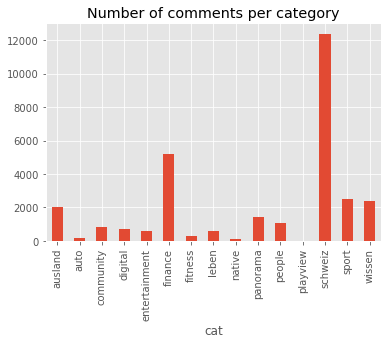

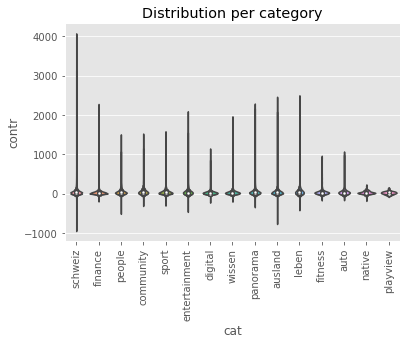

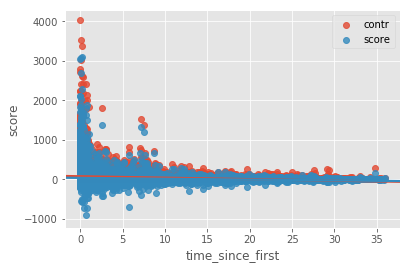

In [170]:
df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# Hist
h = df_merge.groupby(['cat']).size()
h.plot.bar(title='Number of comments per category')
plt.show()

# Distribution
ax = sns.violinplot(x="cat", y="score", data=df_merge)
ax.set_title('Distribution per category')
plt.xticks(rotation = 90)
plt.show()

# Part of mobile users, not interesting enough
#parts_mob = df_merge[df_merge['mob'] == True].groupby(['cat']).size() / df_merge.groupby(['cat']).size()
#parts_mob.plot.bar(title='Mobile comments per category')
#plt.show()

# is empty: (= all comments correspond to an article)
#print(df_merge[pd.isnull(df_merge['link'])])
#df_merge[df_merge['vup']>1000]

# Get order of comments per article
df_merge_art = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')
# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    group = group[group['time_since_first'] < 36]
    return group

df_merge_art = df_merge_art.apply(get_time_since_first)

ax = sns.regplot(x='time_since_first', y='contr', label='contr', data=df_merge_art)
ax = sns.regplot(x='time_since_first', y='score', label='score', data=df_merge_art)
ax.legend()
plt.show()
    
# Summary:
# Score / contr are only possible in certain categories 
#    - the categories with lots of active users
#    - probably the categories with lots of comments (see hist)
# The time of posting compared to the first comment is not as important as I expected it to be
# Exception: Some early comments make it into "top comments" and get very high scores/contr
# But we can say the comment has to be posted about < ~12h after the first comment

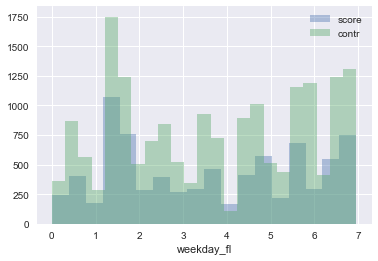

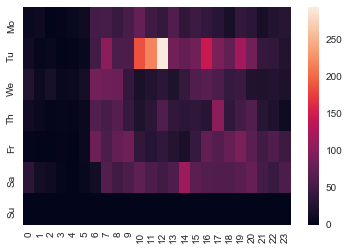

In [16]:
# Plot hist and heat map
sns.set(color_codes=True)
ax = sns.distplot(df_com[df_com['score']>50]['weekday_fl'], label='score', kde=False)
ax = sns.distplot(df_com[df_com['contr']>50]['weekday_fl'], label='contr', kde=False)
ax.legend()
plt.show()
grouped = df_com[df_com['score']>50].groupby(['weekday', 'hour']).size()
matrix = np.zeros((7, 24))
for d in range(0, 6):
    for h in range(0, 24):
        if d in grouped and h in grouped[d]:
            matrix[d][h] = grouped[d][h]

weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
sns.heatmap(matrix, yticklabels=weekdays)
plt.show()

# 0 = Monday, 7 = Sunday
# Summary:
# The day and time of posting plays a big role
# This is probably because on certain days upvoting people are most active
# This does not mean that posting the *same* comment on those times gives you more upvotes
# - it may be possible, but we can't imply that (yet? / not enough data)

In [85]:
# Preprocess and split data
#  - KFold would be better, but for that I have to switch to a compiled language

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# Prepare data for X and y
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

# Preprocessor removes number
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
vect = CountVectorizer(preprocessor=no_numbers, ngram_range=(1, 1), stop_words=stop_words) # Range higher than 1 doesn't help

def classify(val):
    if val > 100: return 1
    return 0

# TODO split this
# For comments
if True:
    X = vect.fit_transform(df_merge['con'])
    y = df_merge['score'].apply(classify)
# For articles, some articles have no text
else:
    X = vect.fit_transform(df_merge[pd.notnull(df_merge['text'])]['text'])
    y = df_merge[pd.notnull(df_merge['text'])]['score'].apply(classify)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#y_scaler = StandardScaler()
#y_train = y_scaler.fit_transform(df_merge['score'][:, None])
#y_test = y.scaler.transform(y_test)

# Summary:
# Removing stop words didn't help the score (didn't add information), 
#   but it makes the model easier to interpret
# N-gram over 1 doesn't give a better score
# min_df / max_df in CountVectorizer make no difference
# Threshold > 100 for classification gives a better prediction than for > 50, 
#   easier to classify because of ...

In [104]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Get best parameter
# This takes some time...
if True:
    from sklearn.model_selection import GridSearchCV
    #param_grid = {'C': np.logspace(-3, 1, 5)}
    param_grid = {'penalty': ['l2', 'elasticnet'], 'n_iter': [5, 10, 50], 'alpha': np.logspace(-5, 1, 5), 'n_jobs': [2]}
    #grid = GridSearchCV(LogisticRegression(), param_grid, cv=3)
    grid = GridSearchCV(SGDClassifier(), param_grid, cv=4)
    grid.fit(X_train, y_train)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best parameters: ", grid.best_params_)
# Just prepare data
else:
    print("Ok")
    
# Summary:
# Even a score of 0.94 is still bad because it's from cross validation

Best cross-validation score: 0.94
Best parameters:  {'alpha': 0.00031622776601683794, 'n_iter': 50, 'n_jobs': 2, 'penalty': 'l2'}


In [105]:
# Build and test a model with the parameters from above
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

#logreg = LogisticRegression(C=1e-1)
logreg = SGDClassifier(penalty='l2', n_iter=50, alpha=1e-3, n_jobs=2)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print("\tR^2: %1.3f" % r2_score(y_test, y_pred))
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

print(y_pred)
# Summary:
#     Model overfits :(
#     I have to add the dependency from weekday and hour, since their influency is too big
#     ...now the words get weighted by the time they got posted

	R^2: -0.069
	Precision: 1.000
	Recall: 0.003
	F1: 0.006

[0 0 0 ..., 0 0 0]


In [103]:
# Understand how coefficients are set / which words are important
coeff_by_name = {}
for i, f in enumerate(vect.get_feature_names()):
    coeff_by_name[f] = logreg.coef_[:, i][0]

coeff_sorted = sorted(coeff_by_name.items(), key=lambda x:x[1], reverse=True)

for c in coeff_sorted[0:30]:
    print("{}\t{}".format(c[0], c[1]))
print("----------")
for c in coeff_sorted[-30:]:
    print("{}\t{}".format(c[0], c[1]))

# Summary comments:
# It seems that making positive comments about something bad that happened
#     gives a lot of upvotes
# Downvotes seem to be received for grumbling and arguing

# Summary articles:
# ~ Ranting about the 20min app etc. gives downvotes
# ~ Ranting about weapons, police, showing sympathy gives upvotes



schweden	0.30284908699011304
task	0.2713527819431418
berset	0.25681602576761586
force	0.25197044037577426
thurgau	0.23743368420024863
tierarzt	0.22531972072064446
kantonstierarzt	0.18413224488998903
nick	0.1841322448899884
taskforce	0.1792866594981471
veterinäramt	0.15505873253893793
behörde	0.15263593984301696
urteil	0.15263593984301674
integration	0.14779035445117505
uno	0.14294476905933354
pensionskassen	0.1380991836674916
matias	0.1356763909715707
ts	0.12840801288380835
tierhalteverbot	0.12598522018788733
tierschutz	0.12598522018788702
behörden	0.12598522018788694
anpassen	0.12598522018788688
schwimmunterricht	0.12356242749196611
linke	0.12113963479604527
regierungsrat	0.1211396347960451
hof	0.12113963479604498
handwerk	0.11871684210012447
künstlerin	0.11871684210012415
montag	0.11871684210012391
fremde	0.11629404940420345
missstände	0.1138712567082825
----------
vermute	-0.060569817398022564
voller	-0.060569817398022675
ausschreitungen	-0.06056981739802271
iraner	-0.06056981739802

### Take Aways so far
Context seems to play a big role in determining up/downvotes, a far bigger role than words used. - This is not surprising, since the number of active readers differs a lot and since words can change their meaning depending on context.  
So maybe the content is not that important, maybe it's more important if it is positive or negative?  
Hypothesis: Earlier comments on an article get more score/contr than later ones (have to check that).

Next steps:
* Build a model for sentiment analysis (maybe start with a simple one, classifying with certain words)
* Explore for and then maybe build prediction model with features: weekday and hour of posting, order of comment (let's continuous first), length of comment (maybe), if it's a positive, neutral or negative one